Код по мотивам лекции о градиентном бустинге над решающими пнями:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 120

In [2]:
# генерация данных
def give_points(n: 'число точек в кластере', seed=1720):
    np.random.seed(seed)
    x = pd.Series(np.r_[np.random.uniform(0, 2, n), np.random.uniform(3, 5, n), 
                    np.random.uniform(5, 7, n), np.random.uniform(7, 9, n)])
    
    target = pd.Series(np.r_[np.random.rand(n) + 0, np.random.rand(n) + 5,
                    np.random.rand(n) + 0, np.random.rand(n) + 3])
    
    return x, target

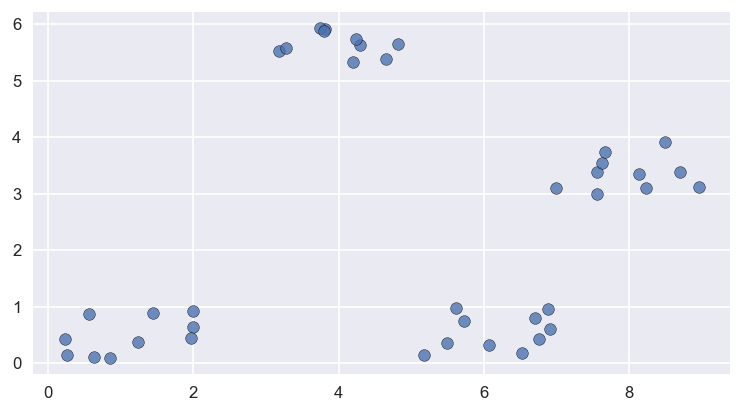

In [8]:
x, target = give_points(10, 315)

plt.figure(figsize=(7.5, 4))

plt.scatter(x, target, ec='k', alpha=0.8);

In [29]:
def H(R, target):
    y = target[R.index]
    if len(y) > 0:
        return np.mean((y - y.mean()) ** 2)
    else:
        return 0


def split_node(R_m, t):
    R_l = R_m[R_m <= t]
    R_r = R_m[R_m > t]
    return R_l, R_r


def q_error(R_m, t, target):
    R_l, R_r = split_node(R_m, t)
    return len(R_l) / len(R_m) * H(R_l, target) + \
            len(R_r) / len(R_m) * H(R_r, target)

In [10]:
def find_best_split(X, target):
    Q_er = []
    feature_values = np.unique(X)
    
    for t in feature_values:
        Q_er.append(q_error(X, t, target))
        
    best_split = (feature_values[np.argmin(Q_er)] + feature_values[np.argmin(Q_er) + 1]) / 2
    
    preds = [target[X <= best_split].mean(), target[X > best_split].mean()]
    return best_split, preds

In [30]:
# оформил модель в стиле scikit-learn
class decision_pen():

    def __init__(self, steps):
        self.steps = steps
        super().__init__()
        pass

    def fit(self, X, target):
        self.target = target
        splits = []
        predictions = []

        for i in range(self.steps):
            best_split, preds = find_best_split(X, self.target)
            splits.append(best_split)
            predictions.append(preds)
            self.splits = splits
            self.predictions = predictions

            y_pred = np.zeros_like(X)
            y_pred[X <= best_split] = preds[0]
            y_pred[X > best_split] = preds[1]

            self.target = self.target - y_pred

        self.mse = np.mean((target - dp.predict(x)) ** 2)
        pass

    def predict(self, X):
        ans = np.zeros_like(X)

        for i in range(len(self.predictions)):
            preds = self.predictions[i]
            best_split = self.splits[i]

            ans[X <= best_split] += preds[0]
            ans[X > best_split] += preds[1]

        return ans

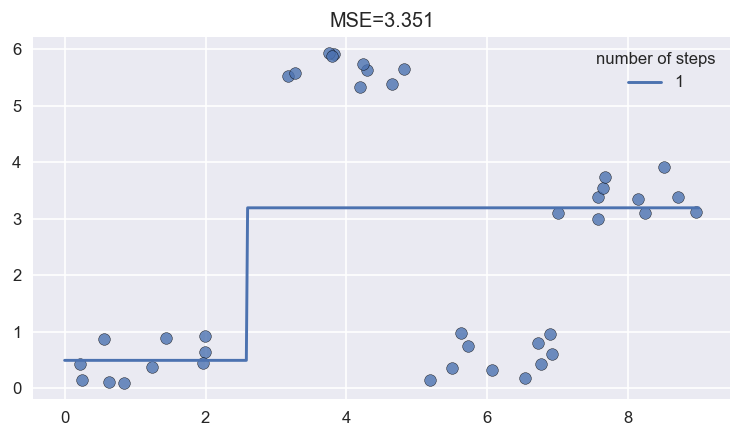

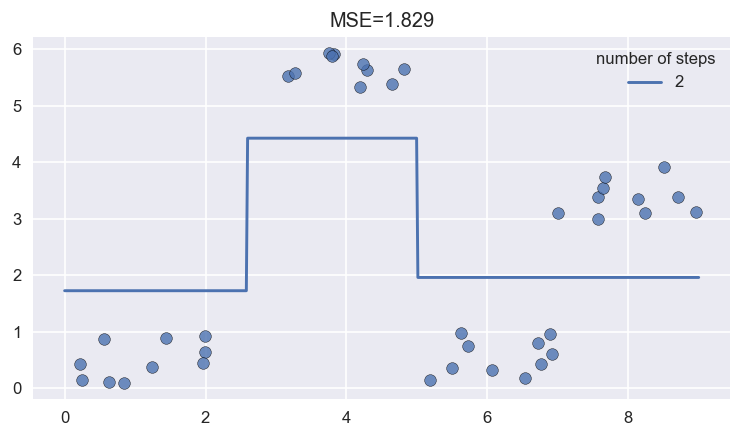

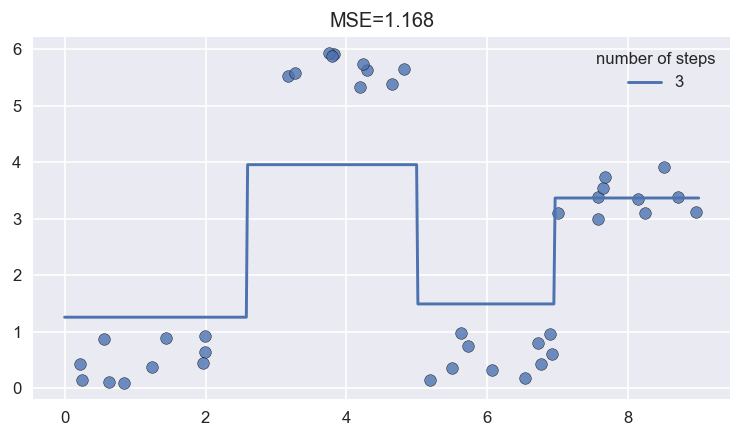

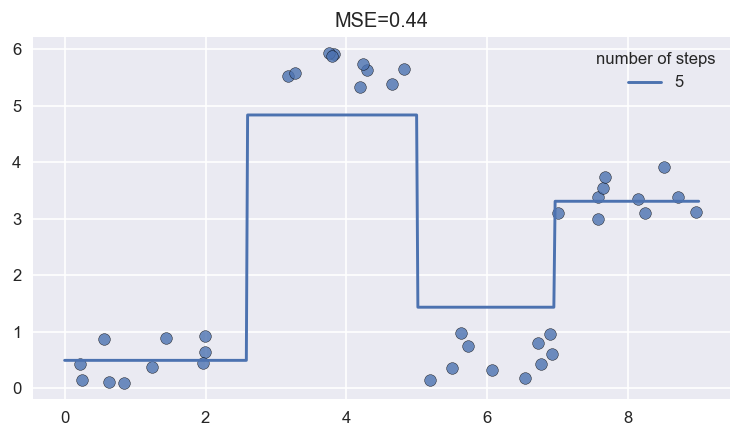

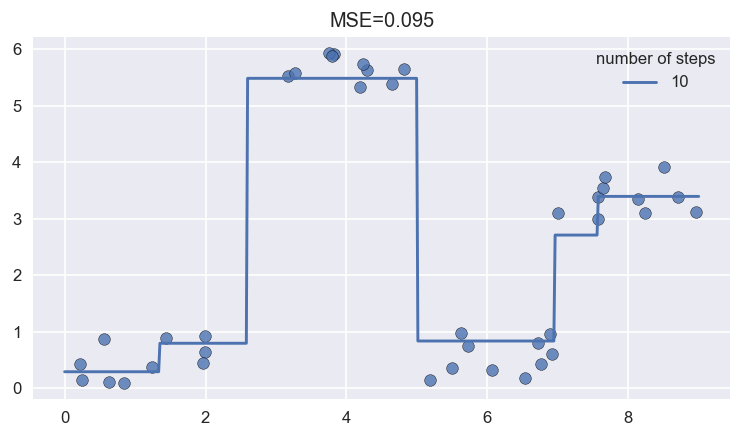

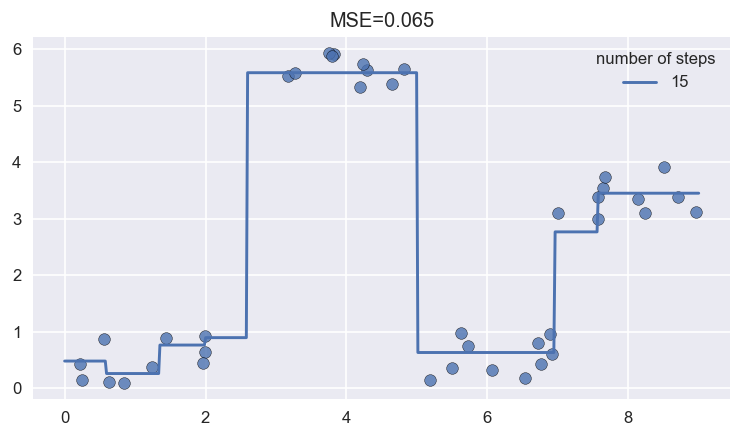

In [34]:
t = np.linspace(0, 9, 500)
for n_steps in [1, 2, 3, 5, 10, 15]:
    dp = decision_pen(n_steps)
    dp.fit(x, target)
    y_pred = dp.predict(t)
    
    plt.figure(figsize=(7.5, 4))
    plt.scatter(x, target, ec='k', alpha=0.8)
    plt.plot(t, y_pred, label='{}'.format(n_steps))
    plt.title('MSE={}'.format(round(dp.mse, 3)))
    plt.legend(title='number of steps');